In [17]:
import pandas as pd
import numpy as np

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files
import requests # library to handle requests
from requests import get
from bs4 import BeautifulSoup
import re
from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns #plot
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



# Capstone Project - The Battle of Neighborhoods (Week 1-2)
**INVESTMENT IN THE VIENNA REAL ESTATE MARKET**

_Author: Yulia Lopez_

## Content:
* <a href='#intro'>1. Introduction and Bussiness problem</a>
* <a href='#meth'>2. Methodology</a>
* <a href='#data'>3. Data</a>
* <a href='#Processing'>4. Data Processing</a>
* <a href='#Vis'>5. Data Visualisation</a>
    * <a href='#Vis'>5.1 District Analysis</a>
    * <a href='#Vis'>5.2 Cluster Analysis</a>
* <a href='#res'>6. Results</a>
* <a href='#dis'>7. Discussion and Conclusion</a>


<a id='intro'></a>
## 1. Introduction and Bussiness problem:

I help for a prospective investor in the Austria real estate market.  The client's view is to attain a foothold in the Vienna market. The property must be within client's ability to service the loan.  Based on client's approach to a bank, they will lend up to 350k EUR on a property. The desired option for the client - appartment with 3-4 rooms, cost less than 350th EUR and located in the nice area (restaraunts, park, cafee around). This project is to help the investor to find most optimal appartments. 

The aim of this project is to overview of Vinna realestate market:

* What district has cheaper accomadation pricing
* What are similiar districts in tearms pf pricing
* What districts suits the client condition

**Interested Audience:** I believe this is an interesting and usufull challenge with valid questions for anyone who considered to make an investment in large cities in EU, etc. The same methodology can be applied in accordance to demands as applicable. This case is also applicable for anyone interested in making an real eastate investment or rellocate. Lastly, it can also serve as a good practical exercise to develop Data Science skills.

<a id='data'></a>
# 2. Data

###  Client Requierements : 
**Ideal property** for client' personal circumstances and cashflow position, - appartment with 3-4 rooms, cost less than 350th EUR and located in the nice area (restaraunts, park, cafee around)

###  Data: 
In order to make a good choice of a appropriate apartment in Vienna, the following data is required: 
* Information of available appartments in Vienna, (location, size, rooms, price) 
* Information on Vienna districts  with Geodata ( latitud and longitud.)
* Venues and ammenities in the Vienna districts suburbs (e.g. top 10). 

In [ ]:
# Get data from realestate website
listing_found = True
page_num = 1
listings = []

while listing_found:
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    url = 'https://www.willhaben.at/iad/immobilien/eigentumswohnung/eigentumswohnung-angebote?areaId=900&page={}&rows=200'.format(page_num)
    response = get(url, headers=headers)     # load the response
    soup = BeautifulSoup(response.text, 'html.parser')
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="content-section isRealestate")
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="info")[0]
            try:
                size = info.find_all('span', class_="desc-left")[0].text.split()[0]
            except:
                size = np.nan
            try:
                rooms = info.find_all('span', class_="desc-left")[0].text.split()[2]
            except:
                rooms = np.nan
            try:
                price = info.find_all('span', class_="pull-right")[0].text.split()[0]
            except:
                price = np.nan

        except:
            size, rooms, price = np.nan

        try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
        except:
            address = None
            postal_code = None
            district = None

        listings.append([postal_code, district, size, rooms, price])
    
    # increase page number
    page_num += 1
    #print(page_num)  # for check
    # for don't overload the site with requests
    sleep(np.random.randint(1,2))   

In [19]:
column_names = ['PostalCode', 'District', 'Size', 'Rooms', 'Price']
sell_properties = pd.DataFrame(listings, columns=column_names)
sell_properties_fin = pd.DataFrame(listings, columns=column_names) # to avoid mess

In [20]:
sell_properties_fin.dtypes

PostalCode    object
District      object
Size          object
Rooms         object
Price         object
dtype: object

In [21]:
print('There are {} apartments for sell in Vienna'.format(sell_properties.shape[0]))

There are 10568 apartments for sell in Vienna


In [22]:
# DataSet of appartments
sell_properties.head()

,PostalCode,District,Size,Rooms,Price
0,1170,Hernals,107,4,"475.000,10"
1,1130,Hietzing,67,3,"399.000,03"
2,1220,Donaustadt,62,2,"329.900,-"
3,1140,Penzing,105,3,"700.000,-"
4,1210,Floridsdorf,110,4,"527.500,-"


<a id='meth'></a>
## 3. Methodology section

In this project, we will direct our efforts on detecting areas of Vienna, Austria that have properties with low cost. We will limit our analysis to area of Vienna only and take in account the investor desires (see Introduction and Data secsion).
1.	The first step includes cleaning and preparing data for analysis: Gathering data from real-estate web-site (https://www.willhaben.at) and forming a dataframe.
2.	At the second step, we ungertake pre-processing of obtained data - cleaning and formatting.
3.	Then we look deep into prepared dataset and undertake analysis of the data in order to have an idea about realestate market in Vienna.
4.	At fourth and final step, we will look for most promising areas that meet requirements of the client venue preferences (restaurants, cafee, park, etc. nearby) by collecting Foursquare data. After that the cluster analysis will be undertaken (using k-means clustering). The result will be a map that shows most areas for the client investment.


<a id='Processing'></a>
# 3. Data Processing

In [23]:
# Cleaning: Exclude all properties with unknown Size, Num. of Rooms,Price and make in same format for statistic
sell_properties_fin['Price'] = sell_properties_fin['Price'].str.replace('.', '').str.replace(',', '.').str.replace('-', '00').str.replace('verkauft', 'NaN')
sell_properties_fin = sell_properties_fin.dropna(axis='index', how='any')

In [24]:
sell_properties_fin['Price'] = sell_properties_fin['Price'].astype('float')
sell_properties_fin['Rooms'] = sell_properties_fin['Rooms'].astype('float')
sell_properties_fin['Size'] = sell_properties_fin['Size'].astype('float')

In [25]:
sell_properties_fin.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
dtype: object

In [26]:
print('There are {} apartments for sell in Vienna'.format(sell_properties_fin.shape[0]))

There are 9760 apartments for sell in Vienna


In [27]:
# Statistic processing: Calculate the price per squared meter
sell_properties_fin['Price/m2'] = (sell_properties_fin['Price']/sell_properties_fin['Size']).round(2)
sell_properties_fin.head()

,PostalCode,District,Size,Rooms,Price,Price/m2
0,1170,Hernals,107.0,4.0,475000.10,4439.25
1,1130,Hietzing,67.0,3.0,399000.03,5955.22
2,1220,Donaustadt,62.0,2.0,329900.00,5320.97
3,1140,Penzing,105.0,3.0,700000.00,6666.67
4,1210,Floridsdorf,110.0,4.0,527500.00,4795.45


In [28]:
# DataSet rough statistics
sell_properties_fin.describe()

,Size,Rooms,Price,Price/m2
count,9760.000000,9760.000000,9.758000e+03,9.758000e+03
mean,80.013132,2.803279,5.107038e+05,7.855546e+03
std,48.281506,1.259305,7.084565e+05,1.520943e+05
min,1.082000,1.000000,1.000000e+00,1.000000e-02
25%,51.000000,2.000000,2.420189e+05,4.367872e+03
50%,69.000000,3.000000,3.400000e+05,5.000005e+03
75%,93.000000,3.000000,4.990000e+05,6.164703e+03
max,771.000000,56.000000,1.314500e+07,1.062847e+07


<a id='Vis'></a>
# 4. Data Visualisation

In [29]:
# Distibution by rooms
sell_properties_fin['Rooms'].value_counts()

2.0     3870
3.0     3445
4.0     1501
1.0      464
5.0      332
6.0       89
7.0       18
8.0       16
9.0       11
15.0       3
19.0       2
14.0       2
24.0       2
11.0       1
56.0       1
21.0       1
13.0       1
10.0       1
Name: Rooms, dtype: int64

In [30]:
# Accounting for the investor wish, accomadation with no more than 3 rooms will be considered
sell_properties_fin2 = sell_properties_fin[sell_properties_fin['Rooms'] <= 4]

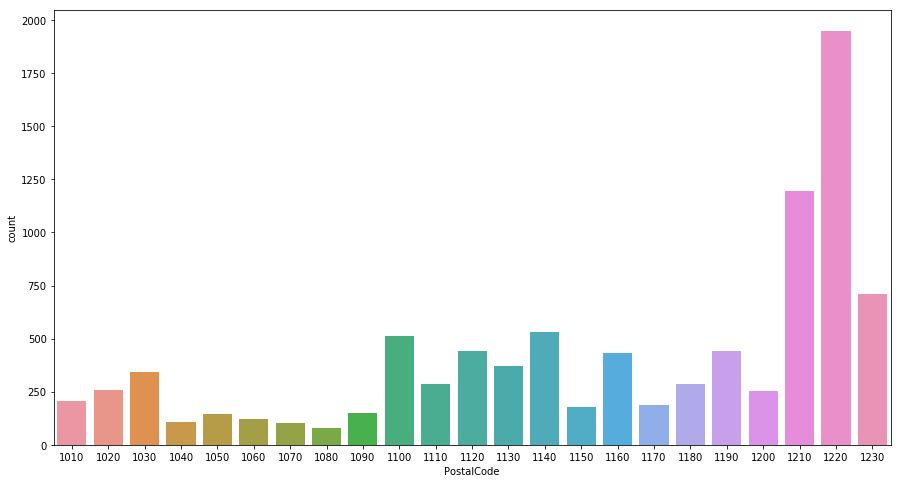

In [31]:
# Visualisating
# Distribution by PostalCode, accomadation with room number <=4
plt.figure(figsize=(15, 8))
sns.countplot(sell_properties_fin2['PostalCode'])

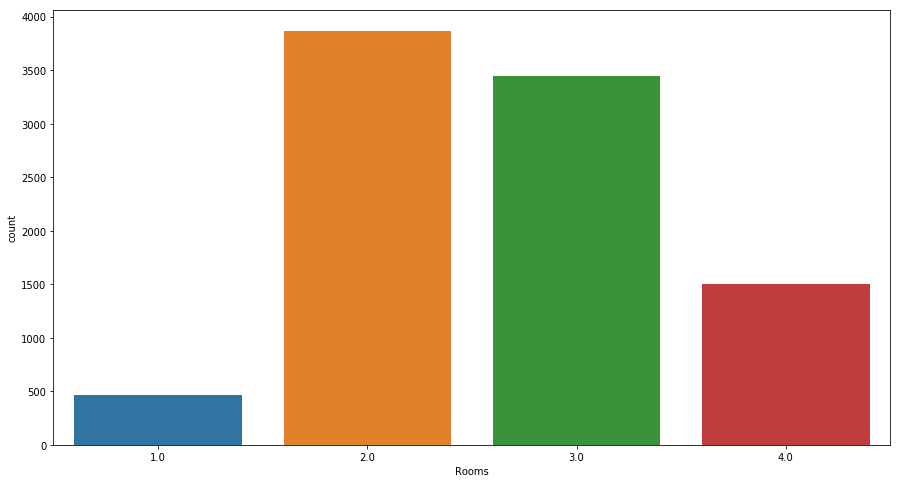

In [32]:
# Rooms distribution
plt.figure(figsize=(15, 8))
sns.countplot(sell_properties_fin2['Rooms'])

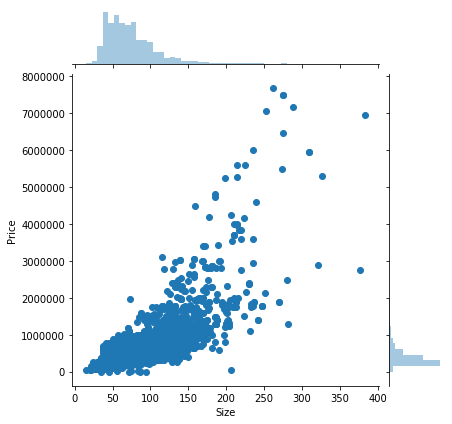

In [33]:
# Plot Size vs Price for all
sns.jointplot(x='Size', y='Price', data=sell_properties_fin2[['Size','Price']])

In [34]:
# Accounting for the investor wish, accomadation cost less then 350k EUR will be considered
sell_properties_fin3 = sell_properties_fin2[sell_properties_fin2['Price'] <= 350000]

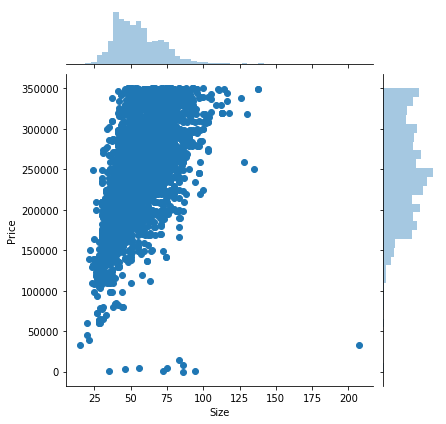

In [35]:
# Plot Size vs Price for num room <=4
sns.jointplot(x='Size', y='Price', data=sell_properties_fin3[['Size','Price']])

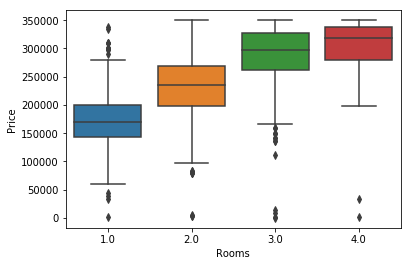

In [36]:
# Previouse pic shows that there is no correlation Size vs Price, so let's check it again, this time Price vs Number of Rooms 
sns.boxplot(x='Rooms', y='Price', data=sell_properties_fin3)

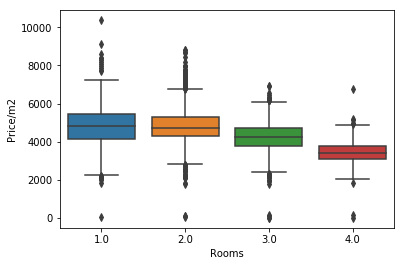

In [37]:
# Investor also asked to find out whether any correlation between number of rooms and size of flat.
sns.boxplot(x='Rooms', y='Price/m2', data=sell_properties_fin3)

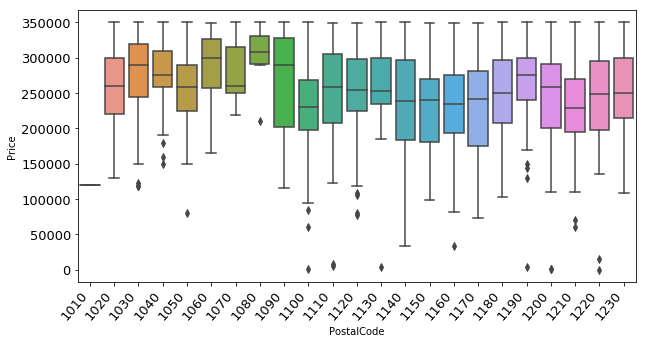

In [38]:
# Check theory of strong correlation
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='PostalCode', y='Price', data=sell_properties_fin3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

To clear results, we should investigate correlation, for client requirements (3-4 rooms)

In [39]:
sell_properties_fin_34b = sell_properties_fin3[sell_properties_fin3['Rooms'] <= 4]

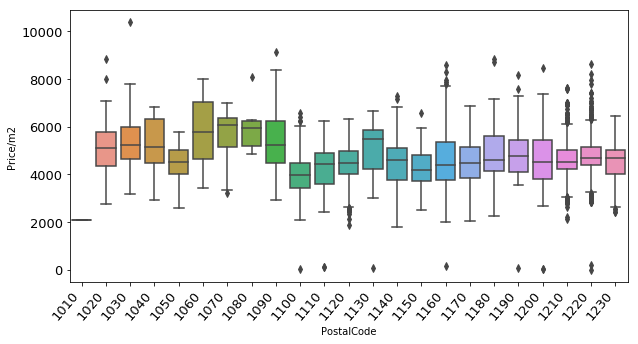

In [40]:
# 2 bedroom
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='PostalCode', y='Price/m2', data=sell_properties_fin_34b)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

# 4.1 Mapping

In [43]:
# Prepare for Mapping - create table with geo-coordinates
vienna_districts = sell_properties_fin_34b[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
latitude = np.zeros(vienna_districts.shape[0])
longitude = np.zeros(vienna_districts.shape[0])
geolocator = Nominatim(user_agent="vienna_explorer")
for idx in range(vienna_districts.shape[0]):
    address = vienna_districts['District'].loc[idx] + ', Wien'
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude
    district_coordinates = vienna_districts

district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

,PostalCode,District,Latitude,Longitude
0,1010,Innere Stadt,48.209133,16.369992
1,1020,Leopoldstadt,48.200638,16.426895
2,1030,Landstraße,48.193644,16.396286
3,1040,Wieden,48.220210,16.371216
4,1050,Margareten,48.188073,16.353386
5,1060,Mariahilf,48.195475,16.347023
6,1070,Neubau,48.201881,16.349056
7,1080,Josefstadt,48.210852,16.347360
8,1090,Alsergrund,48.225073,16.358398
9,1100,Favoriten,48.173423,16.377914


In [44]:
# Creating Vienna districts map
map_vienna = folium.Map(location=[48.2012167,16.3725062], zoom_start=15)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

In [45]:
# calculate the mean by district
mean_per_district = sell_properties_fin2.groupby('District').mean().reset_index()
mean_per_district.head()

,District,Size,Rooms,Price,Price/m2
0,Alsergrund,96.822368,2.914474,858381.532697,7956.407171
1,Brigittenau,64.107143,2.404762,310421.690199,4897.656096
2,Donaustadt,66.394359,2.550256,336449.503195,5026.554656
3,Döbling,101.338636,3.059091,772004.637136,7306.989227
4,Favoriten,68.863548,2.557505,307318.646140,4450.509942


# 4.2 Districts Venue Analysis

In [ ]:
#download json from my github
print('GeoJSON file downloaded!')

In [46]:
with open('wien_geo.json.5') as json_data:
    location_data = json.load(json_data)

In [47]:
location_data['features'] = location_data['features'][:23]

In [48]:
for idx in range(len(location_data['features'])):
    location_data['features'][idx]['properties']['name'] = location_data['features'][idx]['properties']['name'].replace('Wien ','')

In [49]:
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for districts in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

In [71]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: IXB15GUYSCOVQQYICV1Y4U2FZ0OIM1QKGUPHX03UJWK15I1K
CLIENT_SECRET:UQ00LKRU35YOKL52ZSAZMYPXYCZXHJCZHCMDR2L43P0XROH3


In [52]:
# function from the our course
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
# looking for venues
vienna_venues = getNearbyVenues(names=district_coordinates['District'],
                                   latitudes=district_coordinates['Latitude'],
                                   longitudes=district_coordinates['Longitude'],
                                   radius=2000, LIMIT=100)

In [54]:
vienna_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.209133,16.369992,Stephansplatz,48.208299,16.371880,Plaza
1,Innere Stadt,48.209133,16.369992,Kolar,48.210538,16.370033,Gastropub
2,Innere Stadt,48.209133,16.369992,Stephansdom,48.208588,16.373078,Church
3,Innere Stadt,48.209133,16.369992,Park Hyatt Vienna,48.210691,16.367788,Hotel
4,Innere Stadt,48.209133,16.369992,DO & CO Restaurant,48.208240,16.371758,Restaurant


In [55]:
print('{} venues are collected'.format(vienna_venues.shape[0]))

1753 venues are collected


In [56]:
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 217 uniques categories.


In [57]:
vienna_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Alsergrund,100,100,100,100,100,100
Brigittenau,100,100,100,100,100,100
Donaustadt,20,20,20,20,20,20
Döbling,64,64,64,64,64,64
Favoriten,100,100,100,100,100,100
Floridsdorf,44,44,44,44,44,44
Hernals,30,30,30,30,30,30
Hietzing,24,24,24,24,24,24
Innere Stadt,100,100,100,100,100,100


In [60]:
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vienna_onehot['District'] = vienna_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_grouped = vienna_onehot.groupby('District').mean().reset_index()
vienna_grouped

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Alsergrund,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.01,0.01,0.000000,0.020000,0.000000,0.00,0.01,0.00,0.000000
1,Brigittenau,0.00,0.00,0.00,0.00,0.00,0.00,0.020000,0.000000,0.00,...,0.010000,0.00,0.00,0.000000,0.000000,0.010000,0.02,0.00,0.00,0.000000
2,Donaustadt,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000
3,Döbling,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.015625,0.078125,0.000000,0.00,0.00,0.00,0.015625
4,Favoriten,0.00,0.00,0.00,0.03,0.00,0.00,0.040000,0.000000,0.00,...,0.020000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000
5,Floridsdorf,0.00,0.00,0.00,0.00,0.00,0.00,0.022727,0.022727,0.00,...,0.000000,0.00,0.00,0.022727,0.022727,0.022727,0.00,0.00,0.00,0.000000
6,Hernals,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000
7,Hietzing,0.00,0.00,0.00,0.00,0.00,0.00,0.041667,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000
8,Innere Stadt,0.00,0.01,0.00,0.00,0.01,0.00,0.010000,0.000000,0.01,...,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000
9,Josefstadt,0.01,0.00,0.00,0.01,0.02,0.00,0.010000,0.000000,0.00,...,0.000000,0.00,0.01,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.000000


In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = vienna_grouped['District']

for idx in np.arange(vienna_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(vienna_grouped.iloc[idx, :], num_top_venues)


district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Café,Restaurant,Hotel,Coffee Shop,Park,Gastropub,Austrian Restaurant,Italian Restaurant,Bar,Wine Bar
1,Brigittenau,Supermarket,Austrian Restaurant,Italian Restaurant,Plaza,Park,Ice Cream Shop,Gym,Restaurant,Market,Bar
2,Donaustadt,Supermarket,Pizza Place,Bakery,Bus Stop,Breakfast Spot,Café,Metro Station,Sushi Restaurant,Garden,Light Rail Station
3,Döbling,Café,Austrian Restaurant,Restaurant,Wine Bar,Italian Restaurant,Scenic Lookout,Bus Stop,Supermarket,Mountain,Bakery
4,Favoriten,Hotel,Restaurant,Supermarket,Café,Park,Asian Restaurant,Bar,Gym / Fitness Center,Grocery Store,Art Gallery
5,Floridsdorf,Supermarket,Electronics Store,Fast Food Restaurant,Café,Shopping Mall,Grocery Store,Gym / Fitness Center,Tram Station,Mobile Phone Shop,Furniture / Home Store
6,Hernals,Austrian Restaurant,Park,Bus Stop,Café,Scenic Lookout,Restaurant,Climbing Gym,Pool,Comfort Food Restaurant,Pharmacy
7,Hietzing,Park,Supermarket,Bakery,Hotel,Scenic Lookout,Pizza Place,Historic Site,Gym / Fitness Center,Gastropub,Food
8,Innere Stadt,Plaza,Austrian Restaurant,Restaurant,Hotel,Italian Restaurant,Ice Cream Shop,Bar,Café,Boutique,Park
9,Josefstadt,Plaza,Hotel,Coffee Shop,Café,Park,Restaurant,Italian Restaurant,Gym,Ice Cream Shop,Theater


# 4.3 Claster Districts Analysis

In [63]:
# set number of clusters
kclusters = 2
vienna_grouped_clustering = vienna_grouped.drop('District', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

In [64]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# add price/m2 for each district
vienna_merged = pd.merge(district_coordinates, mean_per_district[['District', 'Price/m2']])
# add latitude/longitude for each district
vienna_merged = vienna_merged.join(district_venues_sorted.set_index('District'), on='District')
vienna_merged

,PostalCode,District,Latitude,Longitude,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,Innere Stadt,48.209133,16.369992,14737.351912,0,Plaza,Austrian Restaurant,Restaurant,Hotel,Italian Restaurant,Ice Cream Shop,Bar,Café,Boutique,Park
1,1020,Leopoldstadt,48.200638,16.426895,6314.877220,0,Restaurant,Supermarket,Hotel,Bakery,Café,Austrian Restaurant,Seafood Restaurant,Gastropub,Bus Stop,Asian Restaurant
2,1030,Landstraße,48.193644,16.396286,7154.286569,0,Hotel,Austrian Restaurant,Restaurant,Concert Hall,Café,Asian Restaurant,Art Museum,Pizza Place,Plaza,Lebanese Restaurant
3,1040,Wieden,48.220210,16.371216,6855.917982,0,Restaurant,Café,Austrian Restaurant,Hotel,Plaza,Ice Cream Shop,Park,Bar,Cocktail Bar,Japanese Restaurant
4,1050,Margareten,48.188073,16.353386,5495.454490,0,Austrian Restaurant,Hotel,Bar,Café,Ice Cream Shop,Asian Restaurant,Restaurant,Hostel,Indian Restaurant,Japanese Restaurant
5,1060,Mariahilf,48.195475,16.347023,6640.740496,0,Hotel,Austrian Restaurant,Ice Cream Shop,Japanese Restaurant,Clothing Store,Café,Bar,Hostel,Pizza Place,Coffee Shop
6,1070,Neubau,48.201881,16.349056,7849.114950,0,Hotel,Ice Cream Shop,Plaza,Austrian Restaurant,Theater,Gym,Gym / Fitness Center,Café,Asian Restaurant,Pizza Place
7,1080,Josefstadt,48.210852,16.347360,7903.613077,0,Plaza,Hotel,Coffee Shop,Café,Park,Restaurant,Italian Restaurant,Gym,Ice Cream Shop,Theater
8,1090,Alsergrund,48.225073,16.358398,7956.407171,0,Café,Restaurant,Hotel,Coffee Shop,Park,Gastropub,Austrian Restaurant,Italian Restaurant,Bar,Wine Bar
9,1100,Favoriten,48.173423,16.377914,4450.509942,0,Hotel,Restaurant,Supermarket,Café,Park,Asian Restaurant,Bar,Gym / Fitness Center,Grocery Store,Art Gallery


In [66]:
# create map
map_clusters = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# set colors
rainbow = ['green', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vienna_merged['Latitude'], vienna_merged['Longitude'], vienna_merged['District'], vienna_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Look inside clasters

In [67]:
cluster1 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 0, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster1

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Innere Stadt,0,Plaza,Austrian Restaurant,Restaurant,Hotel,Italian Restaurant,Ice Cream Shop,Bar,Café,Boutique,Park
1,Leopoldstadt,0,Restaurant,Supermarket,Hotel,Bakery,Café,Austrian Restaurant,Seafood Restaurant,Gastropub,Bus Stop,Asian Restaurant
2,Landstraße,0,Hotel,Austrian Restaurant,Restaurant,Concert Hall,Café,Asian Restaurant,Art Museum,Pizza Place,Plaza,Lebanese Restaurant
3,Wieden,0,Restaurant,Café,Austrian Restaurant,Hotel,Plaza,Ice Cream Shop,Park,Bar,Cocktail Bar,Japanese Restaurant
4,Margareten,0,Austrian Restaurant,Hotel,Bar,Café,Ice Cream Shop,Asian Restaurant,Restaurant,Hostel,Indian Restaurant,Japanese Restaurant
5,Mariahilf,0,Hotel,Austrian Restaurant,Ice Cream Shop,Japanese Restaurant,Clothing Store,Café,Bar,Hostel,Pizza Place,Coffee Shop
6,Neubau,0,Hotel,Ice Cream Shop,Plaza,Austrian Restaurant,Theater,Gym,Gym / Fitness Center,Café,Asian Restaurant,Pizza Place
7,Josefstadt,0,Plaza,Hotel,Coffee Shop,Café,Park,Restaurant,Italian Restaurant,Gym,Ice Cream Shop,Theater
8,Alsergrund,0,Café,Restaurant,Hotel,Coffee Shop,Park,Gastropub,Austrian Restaurant,Italian Restaurant,Bar,Wine Bar
9,Favoriten,0,Hotel,Restaurant,Supermarket,Café,Park,Asian Restaurant,Bar,Gym / Fitness Center,Grocery Store,Art Gallery


In [68]:
cluster2 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 1, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster2

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Hietzing,1,Park,Supermarket,Bakery,Hotel,Scenic Lookout,Pizza Place,Historic Site,Gym / Fitness Center,Gastropub,Food
15,Ottakring,1,Supermarket,Austrian Restaurant,Restaurant,Wine Bar,Tram Station,Hotel,Café,Gastropub,Italian Restaurant,Park
17,Währing,1,Supermarket,Café,Park,Ice Cream Shop,Austrian Restaurant,Bakery,Gastropub,Restaurant,Plaza,Italian Restaurant
19,Brigittenau,1,Supermarket,Austrian Restaurant,Italian Restaurant,Plaza,Park,Ice Cream Shop,Gym,Restaurant,Market,Bar
20,Floridsdorf,1,Supermarket,Electronics Store,Fast Food Restaurant,Café,Shopping Mall,Grocery Store,Gym / Fitness Center,Tram Station,Mobile Phone Shop,Furniture / Home Store
21,Donaustadt,1,Supermarket,Pizza Place,Bakery,Bus Stop,Breakfast Spot,Café,Metro Station,Sushi Restaurant,Garden,Light Rail Station
22,Liesing,1,Supermarket,Hotel,Bus Stop,Italian Restaurant,Plaza,Gastropub,Garden,Furniture / Home Store,Platform,Steakhouse


<a id='res'></a>
## 5. Results section 

In [69]:
# vienna_geo = r'BEZIRKSGRENZEOGD.json' # geojson file
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# set colors
marker_colors = ['blue', 'red']

# add markers for e
for idx in range(len(vienna_merged)):
    html_label = ''
    
    lat = vienna_merged['Latitude'].loc[idx]
    lng = vienna_merged['Longitude'].loc[idx]
    district_num = (vienna_merged['PostalCode'].loc[idx])[1:3]
    district = vienna_merged['District'].loc[idx]
    cluster = vienna_merged['Cluster Labels'].loc[idx]
    average_price = vienna_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + str(district_num) + '. ' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(6, 16):
        html_label += '<li>' + vienna_merged.iloc[idx, col]

    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(vienna_map)

# display map
vienna_map

<a id='dis'></a>
## 6. Discussion and Conclusion are in pdf file
where you discuss any observations you noted and any recommendations you can make based on the results.

# THANK YOU FOR YOUR REVIEW!